In [1]:
%matplotlib inline
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

In [2]:
print(tf.__version__)

2.8.0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as ResNet_Pre
from tensorflow.keras.applications.densenet import preprocess_input as DenseNet_Pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as Inception_Pre

In [5]:
model_ResNet = ResNet50(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
model_DenseNet = DenseNet121(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_DenseNet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [7]:
model_InceptionV3 = InceptionV3(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
classes = ["Insulator", "Nest", "Bolt", "Missing_Bolt", "Spacer"]

In [9]:
folder = "Power(ALLcroppedManual)"
q_batch_size = 32

q_directory = "D:\ExtraCources\SummerInter\FewShot\Test\QuerySets\FewShotQuery_" + folder

q_data = tf.keras.preprocessing.image_dataset_from_directory(
    q_directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=q_batch_size,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    # validation_split=None,
    # subset=None,
)

print(len(q_data))

Found 160 files belonging to 5 classes.
5


In [10]:
def make_model(input_len = 5120, nway = 5, hidden_layer1_size = 2048, hidden_layer2_size = 1024, hidden_act_func1 = "relu",
               hidden_act_func2 = "relu", learning_rate = 5e-4, l2_regu_const = 0.1, droupout = 0.05):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.Input(shape=input_len))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(hidden_layer1_size, activation=hidden_act_func1))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(droupout))
    model.add(keras.layers.Dense(hidden_layer2_size, activation=hidden_act_func2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(droupout))
    model.add(keras.layers.Dense(nway, kernel_regularizer=keras.regularizers.L2(l2_regu_const), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    return model

In [11]:
def make_conf_mat(model, q_full_features, q_labels):
    y_pred = tf.argmax(model.predict(q_full_features, batch_size=15, verbose=0), axis=1)
    y_true = tf.argmax(q_labels, axis=1)
    
    conf = tf.math.confusion_matrix(y_true, y_pred).numpy()

    conf_mat_df = pd.DataFrame(conf, index = classes, columns = classes)
    
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(conf_mat_df, annot=True, cmap=plt.cm.Greens)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Split number : 1
Accuracy on query set for split number 1 is : 0.9259259104728699
Average accuracy till now is : 0.9259259104728699


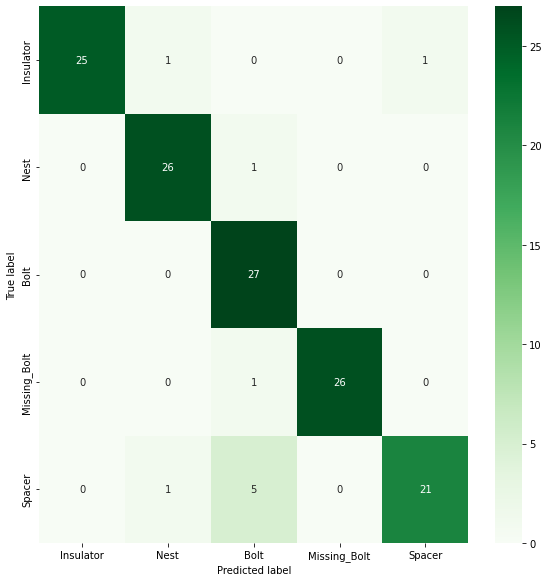

Split number : 2
Accuracy on query set for split number 2 is : 0.9555555582046509
Average accuracy till now is : 0.9407407343387604


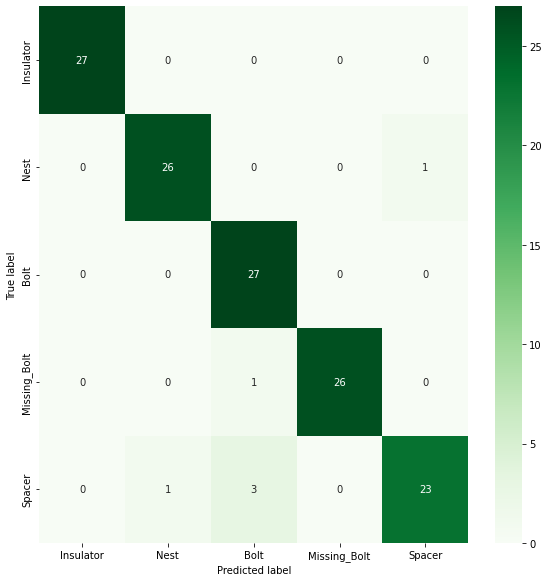

Split number : 3
Accuracy on query set for split number 3 is : 0.9629629850387573
Average accuracy till now is : 0.9481481512387594


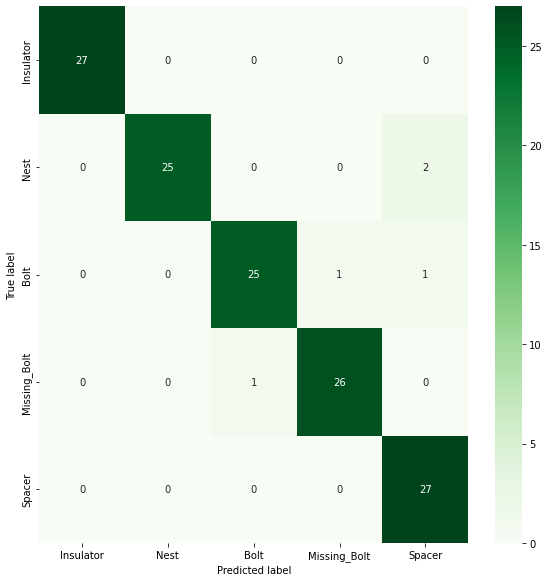

Split number : 4
Accuracy on query set for split number 4 is : 0.9259259104728699
Average accuracy till now is : 0.942592591047287


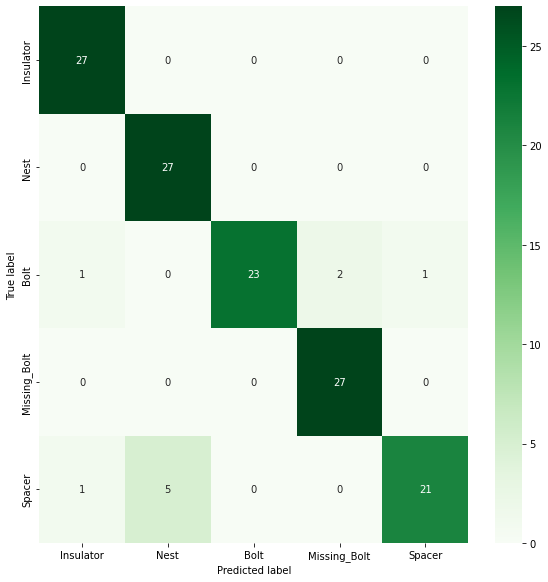

Split number : 5
Accuracy on query set for split number 5 is : 0.8999999761581421
Average accuracy till now is : 0.934074068069458


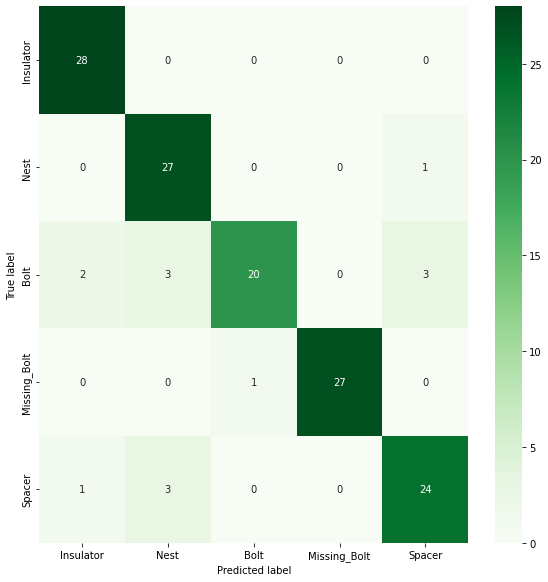

Split number : 6
Accuracy on query set for split number 6 is : 0.9214285612106323
Average accuracy till now is : 0.9319664835929871


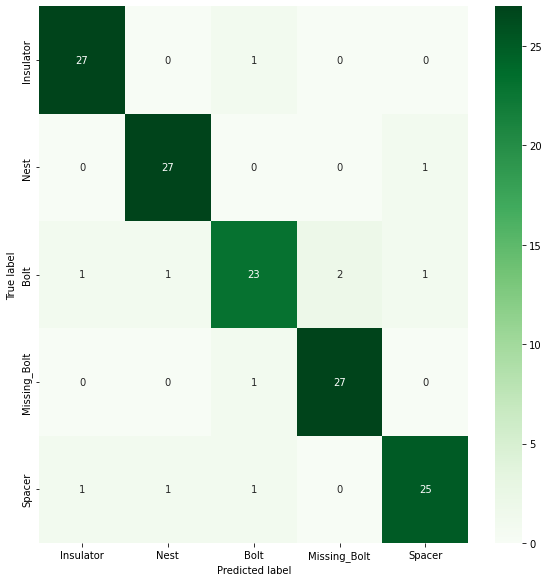

Split number : 7
Accuracy on query set for split number 7 is : 0.9285714030265808
Average accuracy till now is : 0.9314814720835004


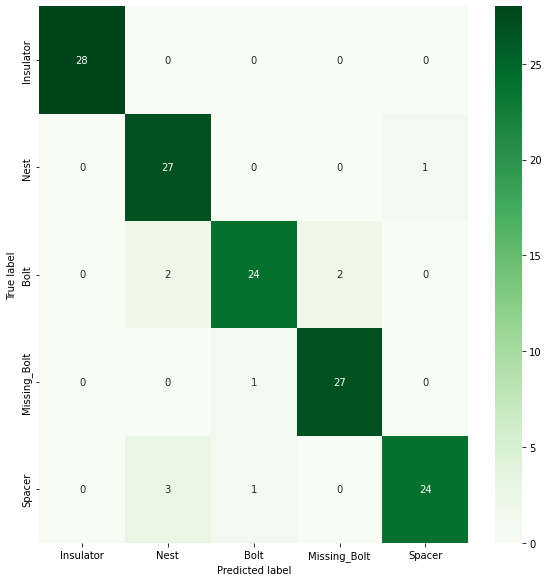

In [12]:
k = 0
running_acc = 0

arr = np.empty(32)
k_fold = KFold(n_splits=7, shuffle=True, random_state=42)

for train_indices, test_indices in k_fold.split(arr):
    
    k += 1
    print("Split number : {}".format(k))
    
    # print('Train: %s | test: %s' % (train_indices, test_indices))

    sup_set = None
    sup_lab = None
    
    q_set = None
    q_lab = None
    
    
    for q in q_data.__iter__():
           
        temp_sup = tf.gather(q[0], test_indices)
        temp_sup_lab = tf.gather(q[1], test_indices)
        
        temp_q = tf.gather(q[0], train_indices)
        temp_q_lab = tf.gather(q[1], train_indices)
        
        if sup_set is None:
            sup_set = temp_sup
        else:
            sup_set = tf.concat([sup_set, temp_sup], 0)
        
        if sup_lab is None:
            sup_lab = temp_sup_lab
        else:
            sup_lab = tf.concat([sup_lab, temp_sup_lab], 0)
            
        if q_set is None:
            q_set = temp_q
        else:
            q_set = tf.concat([q_set, temp_q], 0)
            
        if q_lab is None:
            q_lab = temp_q_lab
        else:
            q_lab = tf.concat([q_lab, temp_q_lab], 0)
        
    
    # break
        
    img_pre_res = ResNet_Pre(sup_set)
    res_features = model_ResNet(img_pre_res)
    
    img_pre_dense = DenseNet_Pre(sup_set)
    dense_features = model_DenseNet(img_pre_dense)
    
    img_pre_inception = Inception_Pre(sup_set)
    inception_features = model_InceptionV3(img_pre_inception)
    
    full_features = tf.concat([res_features, dense_features, inception_features], axis=1)
    labels = sup_lab
    
    
    
    q_img_res_pre = ResNet_Pre(q_set)
    q_res_features = model_ResNet(q_img_res_pre)
    
    q_img_dense_pre = DenseNet_Pre(q_set)
    q_dense_features = model_DenseNet(q_img_dense_pre)
    
    q_img_inception_pre = Inception_Pre(q_set)
    q_inception_features = model_InceptionV3(q_img_inception_pre)
    
    q_full_features = tf.concat([q_res_features, q_dense_features, q_inception_features], axis=1)
    q_labels = q_lab
    
    
    model = make_model()
    
    
    epochs = 300
    batch_size = 5 * 5
    
    history = model.fit(full_features, labels, batch_size=batch_size, epochs=epochs, validation_split=0, verbose=0, shuffle=False)
    
    test_scores = model.evaluate(q_full_features, q_labels, verbose=0)
    

    running_acc += test_scores[1]
    
    print("Accuracy on query set for split number {} is : {}".format(k, test_scores[1]))
    print("Average accuracy till now is : {}".format(running_acc / k))
    
    
    make_conf_mat(model, q_full_features, q_labels)
    

In [13]:
# 92.3 all

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              10487808  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 5125      
                                                        

['Insulator', 'Nest', 'Bolt', 'Missing_Bolt', 'Spacer']


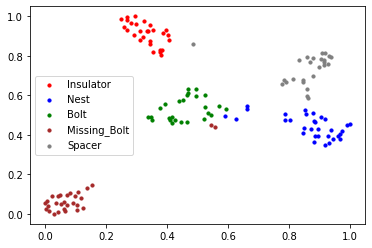

In [30]:
model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
# test_ds = np.concatenate(list(train_ds.take(5).map(lambda x, y : x))) # get five batches of images and convert to numpy array

q_features2 = model2(q_full_features)
labels = tf.argmax(model.predict(q_full_features, batch_size=15, verbose=0), axis=1)
tsne = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(q_features2)

def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

colors = ['red', 'blue', 'green', 'brown', 'gray']
# classes = q_full_features.class_names  
print(classes)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors):
    indices = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, s=10, c=c, label=classes[idx])

ax.legend(loc='best')
plt.show()

In [27]:
# model.save("D:\ExtraCources\SummerInter\FewShot\Test\SavedModels\TF_model_94")